In [1]:
from RLTrain import Opt
import os
import time
#print(Opt())
import pandas as pd

from matplotlib.scale import FuncScale
from RadarGraph import *

import sys
sys.path.append('../')

from visualization_helper import *

# Methods for Trajectory parsing and Visualization

In [2]:
def hashed_trajectories(frame,N=None,N2=None,use_return=False):
    """Turns rollouts into a dictionary of trajectories and counts by hashing episodes based on the actions taken.
    
    Args:
    - frame (dataframe):   Pandas Dataframe containing rollouts
    - N (int):             Number of actions in MultiDiscrete dim 0
    - N2 (int):            Number of actions in MultiDiscrete dim 1
    
    Returns:
    - trajectories (dict): String representations of actions are keys and the number appearances are values
    
    Example: 
    
    >>> print(frame) 
    >>>         InState  Action  Reward  OutState   Done Info  Step
            0  0.631918  [0, 9]     0.0  0.632225  False   {}     0
            1  0.632225  [0, 9]     0.0    0.6319  False   {}     1
            2    0.6319  [4, 4]     0.8    0.6319   True   {}     2
            
    >>> hashed_trajectories(frame)
    >>> {'090944': 1}
    
    """
    min_t,max_t = frame.Step.min(),frame.Step.max()
    mean_act=[]
    
    act = np.stack(frame.Action)  

    trajectories=dict()
    
    if N is None:
        N = np.max(act[:,0])
    act_string=""
    for t,act in enumerate(frame.Action):
        if len(act.shape)<1:
            act0=int(act)
            act=np.zeros((2,),dtype=np.int32)
            act[0]=act0//N2
            act[1] = act0%N2
        act_string+=(str(act[0])+str(act[1]))
        
        if frame.Done[t]:
            if use_return:
                trajectories[act_string] = frame.Reward[t]
            else:
                trajectories[act_string] = trajectories.get(act_string,0)+1
            act_string=""
            
    return trajectories



def relabel_trajectory(trajectory:dict,pouring_actions:set,wait_string:str,
                       end_string,bins_per_action:int,default_wait="1",dependencies=dict()):
    """
    Method to re-label a trajectory such that actions that don't do anything are replaced with waiting and
    the end experiment actions all have the same sub-action value
    """
    new_trajectory=""
    center=str(int(bins_per_action//2))
    i_dependencies={dependencies[a]:a for a in dependencies}
    satisfied= {a:0 for a in dependencies}
    
    for action,param in zip(trajectory[::2],trajectory[1::2]):
        
        if param!="0" and action in i_dependencies:
            satisfied[i_dependencies[action]]+=1
        if param=="0" and action in pouring_actions:
            #Pouring zero amount is the same as waiting
            action=wait_string
            param=default_wait
        elif action in dependencies and not satisfied[action]:
            action=wait_string
            param=default_wait
        #standardize the end experiment action
        if action == end_string:
            param=center
            
        new_trajectory+=action+param
                
    return new_trajectory

def relabel_trajectories(trajectories:dict,pouring_actions:set,wait_string:str,
                         end_string,bins_per_action:int,default_wait="1",dependencies=dict(),use_return=False):
    """
    Recompute a trajectory dictionary using relabel_trajectory
    """
    new_traj=dict()
    #make function calls easier
    relabel=lambda x: relabel_trajectory(x,pouring_actions,wait_string,end_string,bins_per_action,default_wait,dependencies)
    
    for key in trajectories:
        key2 = relabel(key)
        if use_return:
            new_traj[key2]=trajectories[key]
        else:
            new_traj[key2]=new_traj.get(key2,0)+trajectories[key]
    return new_traj

In [171]:
def show_trajectories(trajectories:dict,actions,bins_per_action,figsize=(7,3),alpha_map=lambda x:x**2,max_allowed=1e6, fig_ax=None):

    """
    Plots a dictionary of hashed trajectories with transparency based off of the alpha map
    
    Args:
    - trajectories (dict): Dictionary where keys are the trajectories and values are weights 
            (ex: keys are number trajectory counts, or reward achieved with the trajectory)
    - actions (list of str): List of the names of each action
    - bins_per_action (int): The number of bins for each main action in the multidiscrete
    - figsize (tuple): The size you want the figure to be
    - alpha_map (function): A function that translates normalized values (divided by the max to fit in (-inf,1))
            to alpha values
    - max_allowed (float): The maximum number of trajectories which can be plotted
    
    """

    b = bins_per_action
    tograph = lambda x: [int(i)*10+float(x[2*j+1])*7.8/b+(9-9*.78)/2 for j,i in enumerate(x[::2])]
    
    #order the dict based on frequency
    sorted_hashes = sorted([a for a in trajectories],key=lambda x:trajectories[x],reverse=True)
    sorted_amounts = [trajectories[x] for x in sorted_hashes]
    
    #scale the graph
    L=max(12,len(sorted_hashes[0])//2)
    
    if fig_ax is None:
        fig = plt.figure(1,figsize=figsize, dpi=240, facecolor='w', edgecolor='k')
        ax=plt.gca()

        for j,act in enumerate(actions[::-1]):
            j=len(actions)-j-1
            plt.fill_between([-0.5,L],[j*10-0.5,j*10-0.5],[j*10+9.5,j*10+9.5],label=act,alpha=0.5)
            plt.text(L*0.9875,j*10+5,act,horizontalalignment="right",bbox=dict(boxstyle="square",facecolor="w",edgecolor="k",alpha=0.2))

        plt.xlabel("Step")
        plt.ylabel("Action")
        plt.xlim(-0.5,L)
        plt.ylim(-0.5,len(actions)*10-0.5)
        plt.yticks([])
    
    
    else:
        fig,ax=fig_ax
    for a,string in enumerate(sorted_hashes):
        if a<max_allowed:
            plt.plot(tograph(string),".-",ms=5,alpha=alpha_map(sorted_amounts[a]/sorted_amounts[0]))
        else:break
            

    return fig,ax

# Distillation Bench

In [20]:
parent_dir = "MODELS\\WurtzDistill-v1"
folders = load_rollouts(parent_dir,obj=default_obj,last=False)
dheuristic = pd.read_pickle("MODELS\\WurtzDistill-v1\\Heuristic\\rollout")

## Results During Training

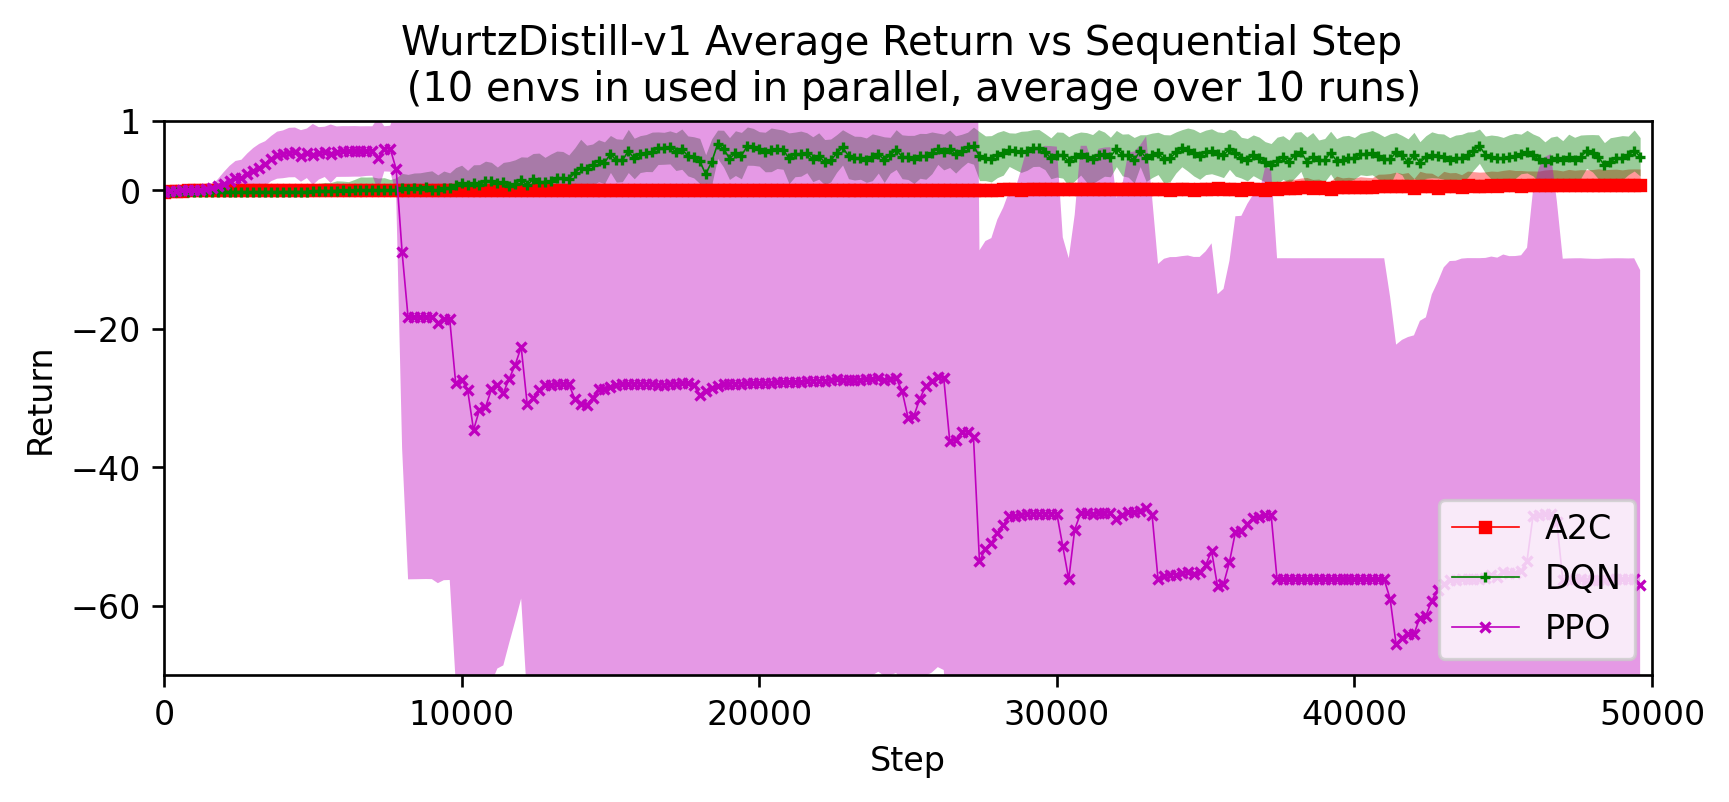

In [21]:
fig = plt.figure(1,figsize=(8,3), dpi=240, facecolor='w', edgecolor='k')

colors = ["r","g","m","b","y","c","k"]
points = ['s', '+', 'x', '.','p',"*","D"]

for i,algo in enumerate(folders):
    subf = parent_dir+"\\"+algo
    returns,counts=merge_varying_graphs(subf,steps=200,separate_runs=False)    
    #Average over the different runs
    mean,stdv,steps,n= mean_stdv_step_n(returns,interp_steps=1,steps=200)
    
    plt.plot(steps,mean,"-",marker=points[i],color=colors[i],label=algo,ms=3,lw=0.5)
    plt.fill_between(steps,mean-stdv,mean+stdv,color=colors[i],alpha=0.4,lw=0)
    
plt.xlim(steps[0],np.ceil(steps[-1]/1e3)*1e3)
plt.xlabel("Step")
plt.ylabel("Return")
plt.legend(loc="lower right")  

plt.yscale(FuncScale(plt.gca(),(lambda x: x*(x>0)+x*(x<=0)/10,lambda x: x*(x>0)+x*(x<=0)*10)))
plt.yticks([-60,-40,-20,0,1])

plt.ylim(-70,1)

plt.title("WurtzDistill-v1 Average Return vs Sequential Step \n (10 envs in used in parallel, average over 10 runs)")

plt.show()

# Looking at trajectories

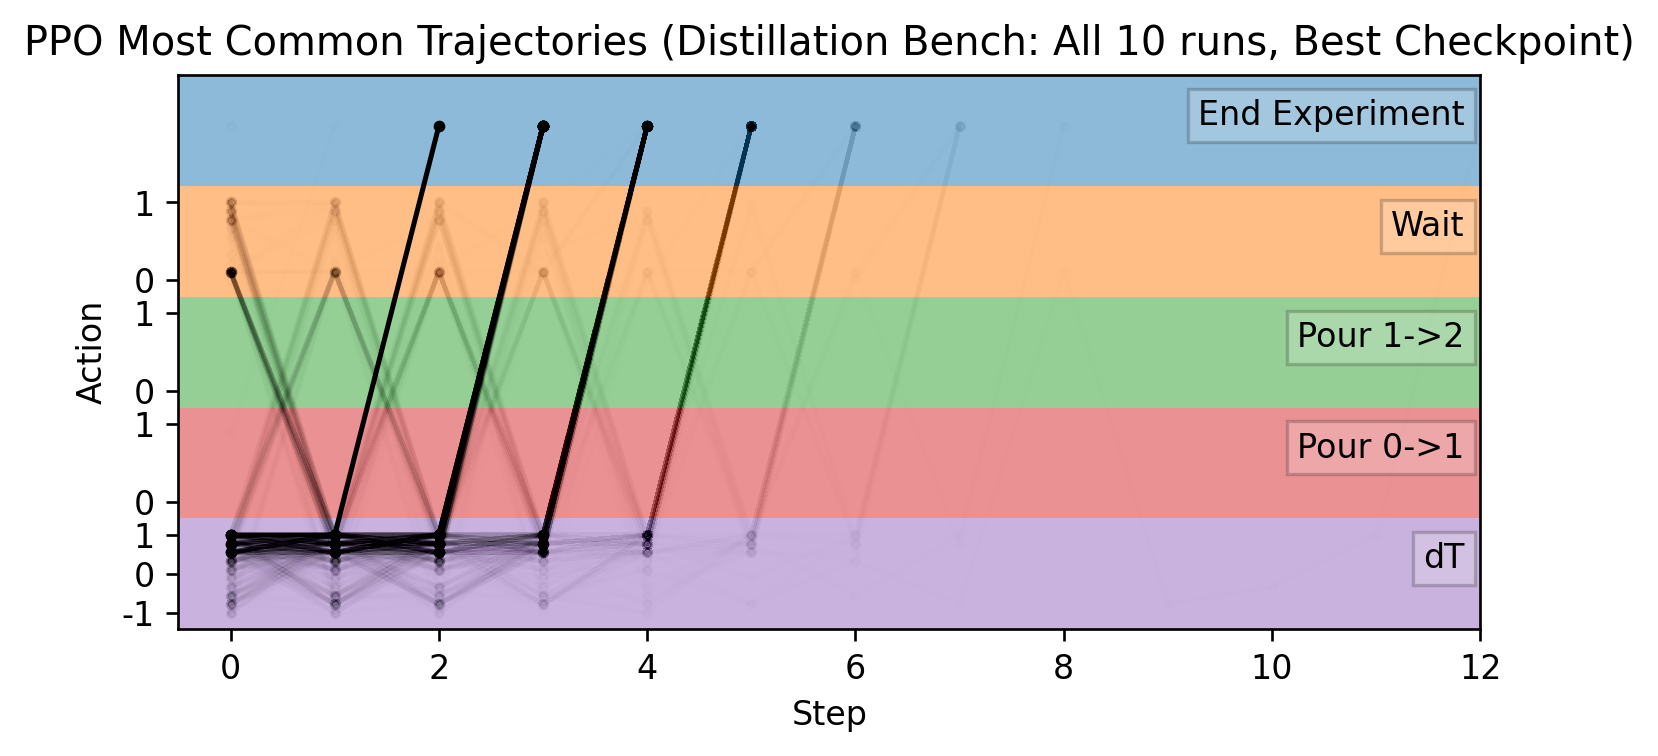

In [41]:
actions = ['dT', 'Pour 0->1', 'Pour 1->2', 'Wait', 'End Experiment' ]

raw_trajectories=hashed_trajectories(folders["PPO"],N=4,N2=10)


dependencies={"2":"1"}
quantized_trajectories=relabel_trajectories(raw_trajectories,{"1","2"},"3","4",10,dependencies=dependencies)

show_trajectories(quantized_trajectories,actions,10,alpha_map=lambda x:x,max_allowed=5e2)
plt.title("PPO Most Common Trajectories (Distillation Bench: All 10 runs, Best Checkpoint)")
plt.yticks([1,4.5,8,11,18,21,28,31,38],[-1,0,1,0,1,0,1,0,1])
plt.show()

# Extraction Bench

In [42]:
parent_dir = "MODELS\\DiscreteWurtzExtract-v1"
#parent_dir="MODELS\\DiscreteWurtzExtract-v1\\PPO-XL\\13-03-2023--06-08-15"
folders = load_rollouts(parent_dir,obj=default_obj,last=False)

eheuristic = pd.read_pickle("MODELS\\WurtzExtract-v1\\Heuristic\\rollout")

## Results During Training

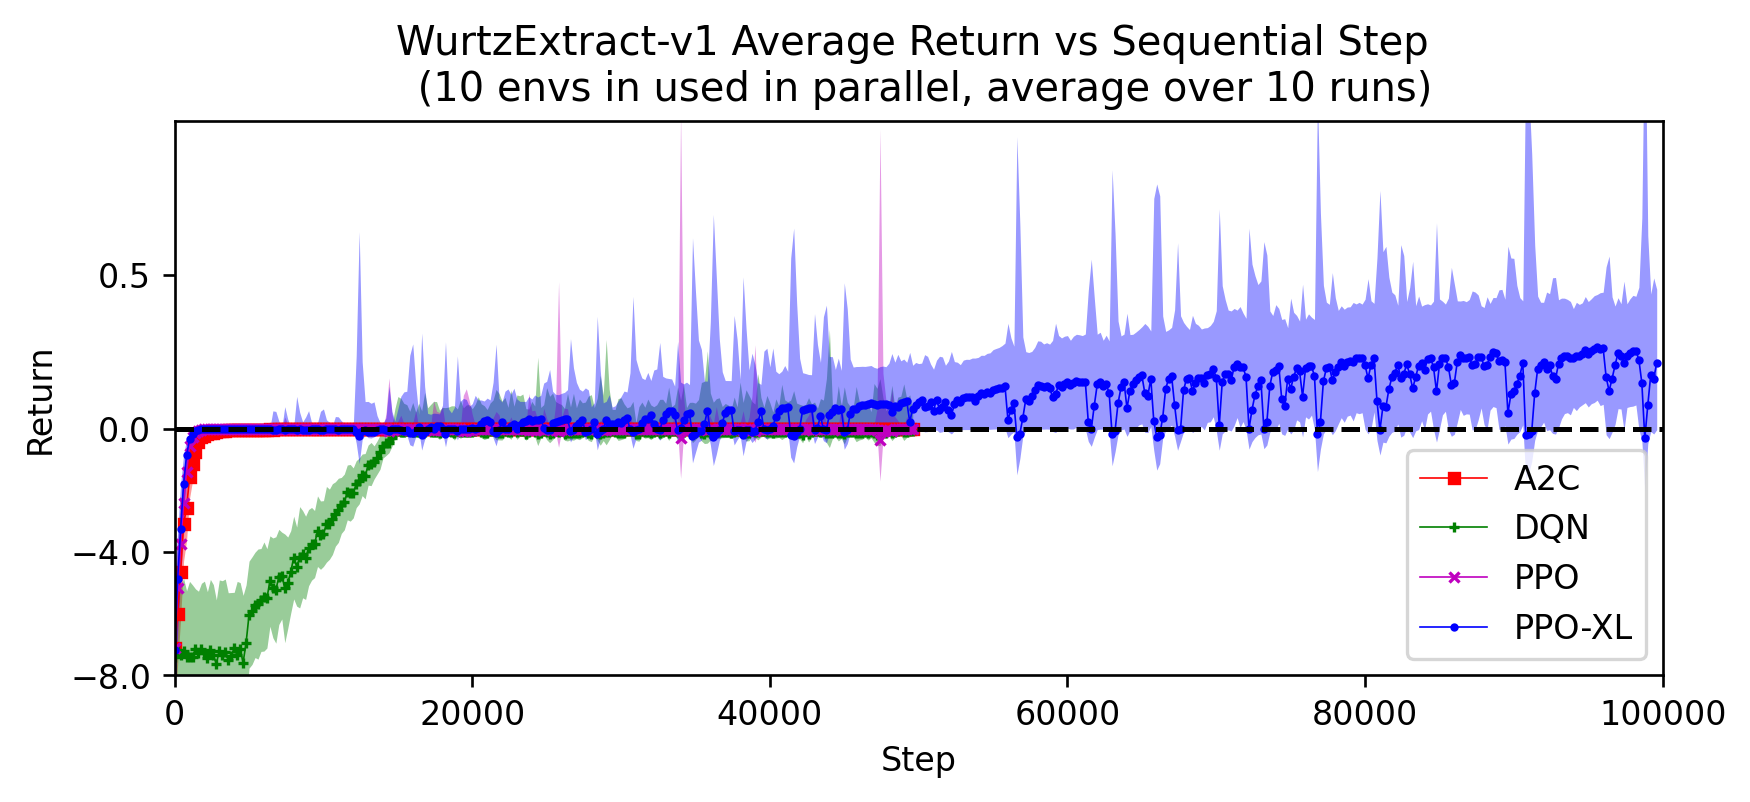

In [43]:
fig = plt.figure(1,figsize=(8,3), dpi=240, facecolor='w', edgecolor='k')

colors = ["r","g","m","b","y","c","k"]
points = ['s', '+', 'x', '.','p',"*","D"]

for i,algo in enumerate(folders):
    subf = parent_dir+"\\"+algo
    returns,counts=merge_varying_graphs(subf,steps=200,separate_runs=False)    
    #Average over the different runs
    mean,stdv,steps,n= mean_stdv_step_n(returns,interp_steps=1,steps=200)
    
    plt.plot(steps,mean,"-",marker=points[i],color=colors[i],label=algo,ms=3,lw=0.5)
    plt.fill_between(steps,mean-stdv,mean+stdv,color=colors[i],alpha=0.4,lw=0)
    
    
plt.xlim(steps[0],np.ceil(steps[-1]/1e3)*1e3)
plt.xlabel("Step")
plt.ylabel("Return")
plt.legend(loc="lower right")  
plt.ylim(-8,1)
plt.yscale(FuncScale(plt.gca(),(lambda x: x*(x>0)+x*(x<=0)/10,lambda x: x*(x>0)+x*(x<=0)*10)))
plt.plot([0,np.ceil(steps[-1]/1e3)*1e3],[0,0],"k--")
plt.yticks([-8,-4,0,0.5])

plt.title("WurtzExtract-v1 Average Return vs Sequential Step \n (10 envs in used in parallel, average over 10 runs)")

plt.show()

# Looking at Trajectories

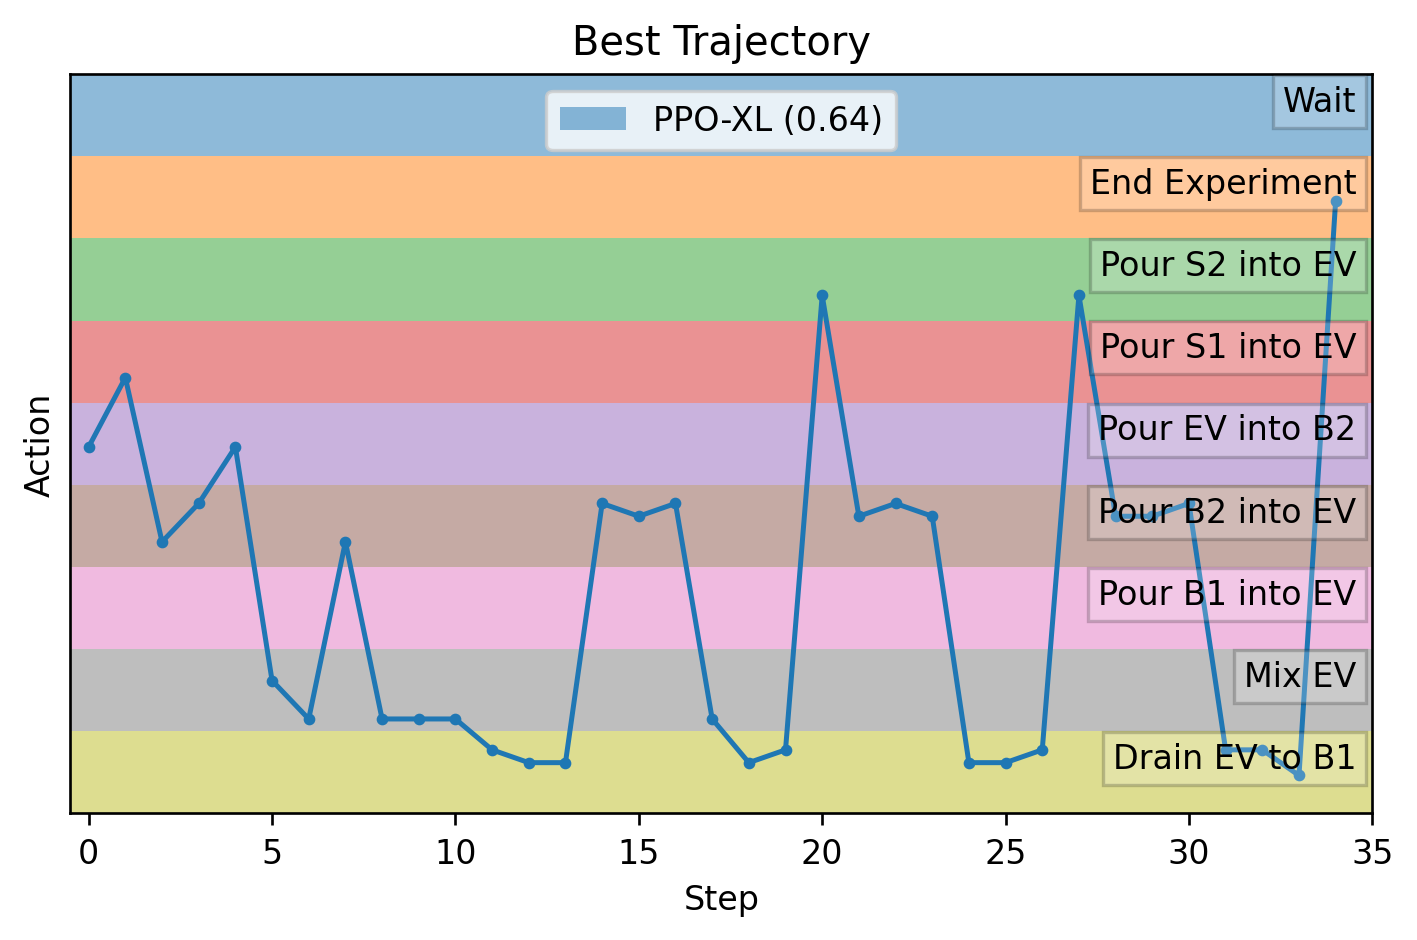

In [342]:
#folders = load_rollouts("MODELS\\DiscreteWurtzExtract-v1",obj=default_obj,last=False,TOL=0,verbose=False)
#folders = load_rollouts("Legacy\\Legacy5\\MODELS\\DiscreteWurtzExtract-v1")


actions=["Drain EV to B1", "Mix EV","Pour B1 into EV","Pour B2 into EV", 
            "Pour EV into B2", "Pour S1 into EV", "Pour S2 into EV","End Experiment","Wait"]
dependencies={"2":"0","3":"4"}


figax=None

legend=[]

for alg in ["PPO-XL"]:#["PPO-XL","PPO","A2C","DQN"]:


    
    raw_trajectories=hashed_trajectories(folders[alg],N=7,N2=5,use_return=True)
    quantized_trajectories=relabel_trajectories(raw_trajectories,{"0","2","3","4","5","6"},"8","7",5
                                                ,default_wait="2",dependencies=dependencies,use_return=True)

    sorted_hashes = sorted([a for a in quantized_trajectories],key=lambda x:quantized_trajectories[x],reverse=True)
    sorted_amounts = [quantized_trajectories[x] for x in sorted_hashes]
    legend.append(f"{alg} (%.2f)"%sorted_amounts[0])
    
    figax=show_trajectories(quantized_trajectories, actions, 5, figsize=(7,4), max_allowed=1, fig_ax=figax)

figax[1].legend(legend,loc="upper center")
plt.title("Best Trajectory")
#plt.yticks([1,4.5,8,11,18,21,28,31,38],[-1,0,1,0,1,0,1,0,1])
plt.show()

In [46]:
sorted_hashes = sorted([a for a in quantized_trajectories],key=lambda x:quantized_trajectories[x],reverse=True)
sorted_amounts = [quantized_trajectories[x] for x in sorted_hashes]



In [47]:
sorted_hashes[0],sorted_amounts[0]

('125111030372', 0.04835576140118364)

In [343]:
def show_trajectories3D(trajectories:dict,actions,bins_per_action,figsize=(7,3),alpha_map=lambda x:x**2,max_allowed=1e6):

    """
    Plots a dictionary of hashed trajectories with transparency based off of the alpha map
    
    Args:
    - trajectories (dict): Dictionary where keys are the trajectories and values are weights 
            (ex: keys are number trajectory counts, or reward achieved with the trajectory)
    - actions (list of str): List of the names of each action
    - bins_per_action (int): The number of bins for each main action in the multidiscrete
    - figsize (tuple): The size you want the figure to be
    - alpha_map (function): A function that translates normalized values (divided by the max to fit in (-inf,1))
            to alpha values
    - max_allowed (float): The maximum number of trajectories which can be plotted
    
    """

    b = bins_per_action
    #actions
    to_z = lambda x: [int(i) for j,i in enumerate(x[::2])]
    #sub-values
    to_y = lambda x: [int(x[2*j+1]) for j,i in enumerate(x[::2])]
    #steps
    to_x = lambda x: [j for j,_ in enumerate(x[::2])]
    
    #order the dict based on frequency
    sorted_hashes = sorted([a for a in trajectories],key=lambda x:trajectories[x],reverse=True)
    sorted_amounts = [trajectories[x] for x in sorted_hashes]
    
    #scale the graph
    L=max(1,len(sorted_hashes[0])//2+11.8)
    
    
    fig = plt.figure(1,figsize=figsize, dpi=240, facecolor='w', edgecolor='k')
    ax = plt.axes(projection='3d')

    colors="rgbcymrgbcym"
    for j,act in enumerate(actions[::-1]):
        j2=len(actions)-j-1
        ax.bar3d([0],[bins_per_action],[j2],[L],[0],[1],color=colors[j],alpha=0.5)
        ax.text(L-11.8,bins_per_action,j2,actions[j2])

    for a,string in enumerate(sorted_hashes):
        if a<max_allowed:
            x = np.array(to_x(string))
            y = np.array(to_y(string))
            z = np.array(to_z(string))
            ones=x*0+1
            ax.bar3d(x,bins_per_action-y,z,ones,y,ones)
            ax.plot(x+0.5,bins_per_action-y*0,z+0.5,"k.-")

        else:break
            
    ax.set_xlabel("Step")
    ax.set_zlabel("Action")
    ax.set_ylabel("Sub-Value")
    #ax.set_xlim(-3,L+3)
    #ax.set_ylim(-2,len(actions)+2)
    ax.set_zticks([])
    ax.set_yticks([])
    return fig,ax

C:\Users\sprag\AppData\Local\Temp\ipykernel_11004\1666242025.py:4: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


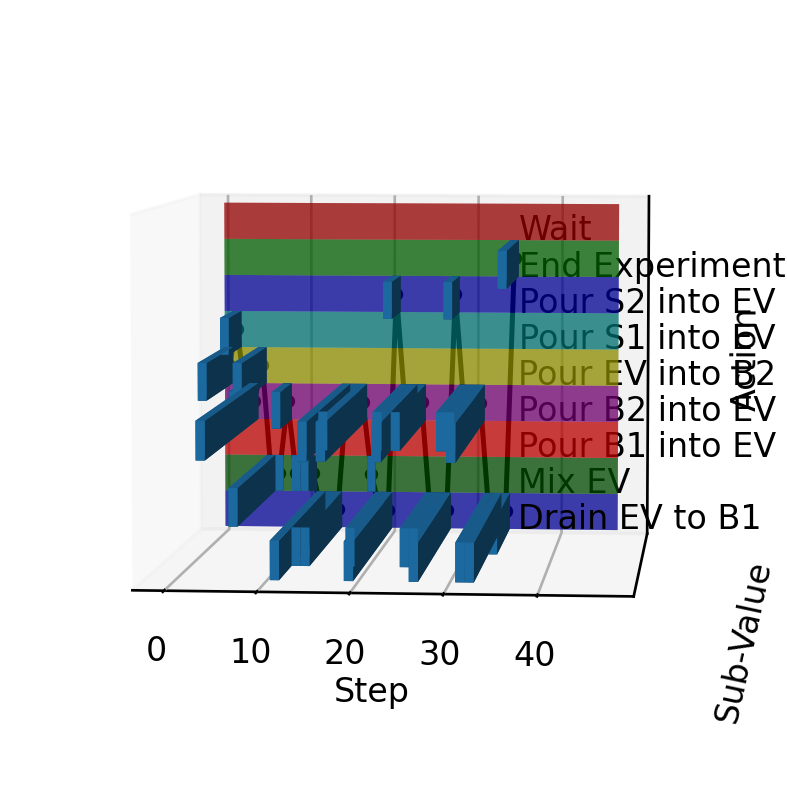

In [346]:
fig,ax = show_trajectories3D(quantized_trajectories,actions,5,figsize=(7,4),alpha_map=func,max_allowed=1)

ax.azim = -85
ax.dist = 10
ax.elev = 5

In [13]:
rewards = folders["PPO-XL"][folders["PPO-XL"].Done==True].Reward

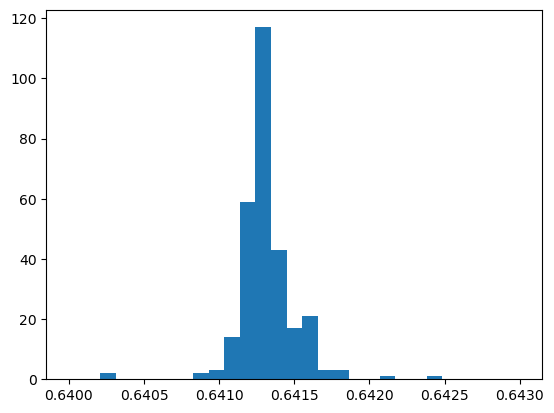

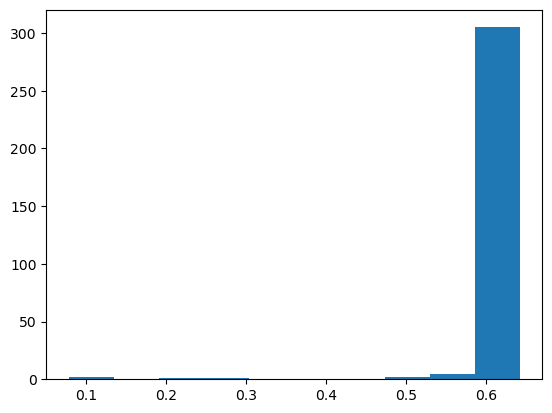

In [14]:
counts,bins,_ = plt.hist(rewards,bins=np.linspace(0.64,0.643,30))
plt.show()
_=plt.hist(rewards)

In [15]:
counts.sum()

286.0

In [16]:
rewards.shape

(316,)

In [17]:
286/316

0.9050632911392406